這篇notebook是在kaggle環境寫成，主要是記錄自己的**第一個完整機器學習模型**，以供日後精進自我使用。

當初做這個模型是為了在台灣人工智慧共創平台的 **<半導體光學AOI圖像檢測>** 練習區小試一下身手，不過基於平台保密原則，我不能透漏實際程式碼，僅就最簡版本討論，實際使用的不是這個版本。

第一次上交成果，便取得了第90名/1626人的佳績(有842人順利提交程式碼):
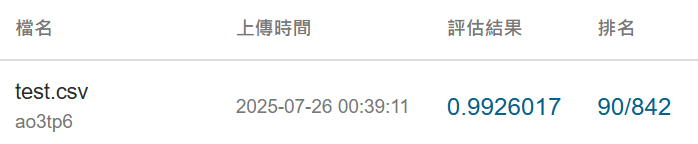

## **1.Kaggle前置作業:**

**為何選用Kaggle平台?**
* 一個月有30小時免費GPU(訓練前記得設定，不然模型會跑一整天...)
* 介面乾淨、input/output資料集顯眼，直接複製路徑就好
* 資料科學家的首選平台，時不時有一些比賽，待日後技術成熟後會慢慢挑戰

不過kaggle也是有不方便的地方，和colab相比，對於外部函式庫的包容性較低，導致很多高階封裝函式庫無法使用。

**訓練資料準備:**

接下來要使用fastai函式庫來做訓練，要先將訓練資料(含有標籤的圖片資料夾)準備好，對fastai來說，最方便的訓練資料路徑莫過於把標籤(Label)作為檔名，也就是這樣的路徑:

In [ ]:
#以一個分辨鳥和樹林的模型為例:

bird_or_not/
├── forest/
│   ├── forest1.jpg
│   ├── forest2.jpg
│   └── ...
└── bird/
    ├── bird1.jpg
    ├── bird2.jpg
    └── ...

不過，有些競賽或練習區資料集是以下列路徑展開，那就寫個程式調一下即可:

In [ ]:
/dataset/
├── images/ #所有照片，可能混在一起
│   ├── img001.jpg
│   ├── img002.jpg
│   └── img003.jpg
└── labels.csv  # 裡面第一欄是圖片檔名，第二欄是對應Label，之類的


In [ ]:
#用這段:

import pandas as pd
from pathlib import Path
import shutil

# 設定路徑
df = pd.read_csv('/kaggle/input/專案/訓練.csv') 
image_folder = Path('/kaggle/input/專案/train_images/train_images')
output_folder = Path('/kaggle/working/dataset_sorted') #新建立的分類資料夾
output_folder.mkdir(exist_ok=True)

# 逐行處理圖片
for _, row in df.iterrows():
    filename = row['ID']
    label = str(row['Label']) #看你的欄位名稱，ID、Label要改
    
    src = image_folder / filename
    dest = output_folder / label
    dest.mkdir(exist_ok=True)
    
    shutil.copy(src, dest / filename)  #複製過去（如果你要移動用 shutil.move）

#現在，我們得到排好的output資料了!

## **2.ResNet18初登場:**

**ResNet系列**本身是一個架構（如 ResNet18、34、50、101），是預訓練模型，也就是權重(Weight)都預先調好了，可以直接做遷移學習（transfer learning）。

這次選用ResNet18是因為數字越小，訓練越快速(實測18發現需要跑一小時，就不想動34了...)，不然其實數字越大，模型參數越多樣，自然也學得越精細。但更難調，且要訓練很多次，並得克服過擬合(over-fitting)問題。

接下來利用fastai函式庫讓ResNet18學習，以下是最經典的初階程式碼，相信如果有自學fastai的人都會心一笑了:

In [ ]:
#最簡程式碼:

from fastai.vision.all import *

# 設定資料夾路徑
path = Path('/kaggle/working/sorted_images')  # 就是剛剛分類好資料的資料夾位置

# 建立資料加載器
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),                 # 影像 + 分類標籤
    get_items=get_image_files,                          # 把所有圖片讀進來
    splitter=RandomSplitter(valid_pct=0.2, seed=42),    # 保留 20%的圖片作為驗證組，訓練過程會告訴你錯誤率，日後比較好調整
    get_y=parent_label,                                 # 用圖片所在資料夾名當作標籤
    item_tfms=[Resize(192, method='squish')]            # 把圖縮放到 192x192(但聽說224x224是最佳的，改天再試)
).dataloaders(path, bs=32)                              # bs是 batch size，一次幾張圖的意思

#模型開始學習
learn = vision_learner(dls, resnet18, metrics=error_rate, wd=3.6400812584222486e-06)
learn.fine_tune(8,base_lr=0.009299868508527199)

可以看到該段程式碼有不少參數可調:

倒數第二行有:
* 模型(先用18)
* wd(其實是lambda，即抑制權重過大的利器，必須取得最適當的值)

倒數第一行有:
* epoch (就是讓模型進行幾次學習)
* base_lr(就是學習率，可以決定學習的"步伐大小"，一樣要挑最適當值)

如何得知所有最佳epoch、lambda、learning rate組合?

這就是所謂的**超參數搜尋**(Hyperparameter Tuning）。

## **3.超參數搜尋:**

使用optuna函式庫來探索最佳參數組合，基本上就是改造上方那段程式碼。

(記得先pip install optuna，至於kaggle環境的話本身就有安裝了)

In [ ]:
import optuna
from fastai.vision.all import *

def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2) #從10的-5次方試驗到-2次方的意思，數值範圍可以自己調
    wd = trial.suggest_loguniform('wd', 1e-6, 1e-2) #一樣，這就是為甚麼人家說optuna很好擴展
    epochs = trial.suggest_int('epochs', 3, 10)

    dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, item_tfms=Resize(192), bs=32)
    learn = vision_learner(dls, resnet18, metrics=error_rate)
    learn.fine_tune(epochs, base_lr=lr, wd=wd)
    
    return learn.validate()[1]  # 回傳 error_rate

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Best trial:', study.best_trial.params) #印出最終結果!

因此，我們得到最佳參數組合了，比起自己手動嘗試，**optuna更逼近微調準度的極限**，直接代入進去。

不過還不夠，有些圖片模糊不清，可以透過增添現實生活的變化增強圖片特徵，幫助機器來做學習，繼續改造剛剛的程式碼:

## **4.圖片特徵增強:**

In [ ]:
#比剛剛多修改dls的部分而已

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')],

    #以上跟剛剛都一樣，只是多這一行:
    
    batch_tfms=aug_transforms(flip_vert=True, max_zoom=1.2, max_warp=0.2)
).dataloaders(path, bs=32)

**解釋:**

| 參數               | 意義                     | 效果                        |
| ---------------- | ---------------------- | ------------------------- |
| `flip_vert=True` | 垂直翻轉（上下翻）              | 模擬可能角度變化（適用於如動物等可倒轉的物體） |
| `max_zoom=1.2`   | 隨機放大最多 20%             | 模擬拍照距離不同                  |
| `max_warp=0.2`   | 隨機形變（perspective warp） | 模擬拍照角度傾斜、變形               |

這樣就能讓模型學會各種現實中的變化，讓模型"看多了"後，反而準確率更高。不過也是要看狀況啦，比方說半導體光學IOC檢測照片的距離通常一致，就不用多這部分了。

移除Optuna函式庫、加入照片處理程式碼、並確保填入最佳參數組合後，就可以訓練模型了。待訓練完畢就是無需更動的完整模型，為了方便日後拿來檢測未知標籤的照片，或是參與競賽，要先下載整個模型，日後再作調用:

## **5.下載訓練完的模型:**

In [ ]:
#對，只有一行。以kaggle為例，輸出到/kaggle/working，機器學習模型是pkl檔

learn.export('/kaggle/working/aoi_model.pkl')

假設你有需要分類的圖像，以及一個第一行為圖片檔名，第二行打算存放預測結果的csv檔，就可調用模型來預測囉:

## **6.預測圖片分類:**

In [ ]:
# 這行負責載入剛剛的模型
learn = load_learner('/kaggle/working/aoi_model.pkl')  

# 讀取 CSV
df = pd.read_csv('/kaggle/input/aidea-aoi/test.csv')

# 存放預測結果
preds = []

# 預測每張圖片
for fname in df['ID']:
    img_path = Path('/kaggle/input/專案/test_images') / fname
    pred_class, pred_idx, outputs = learn.predict(img_path)
    preds.append(pred_class)

# 加入存放預測結果的新欄位
df['Label'] = preds

# 儲存成新的 CSV
df.to_csv('/kaggle/working/test.csv', index=False)

這部分要跑非常久，有時候notebook的介面會當掉，**切勿refresh**，因為有可能後端仍有在跑，正確做法是用另一個分頁進入同樣的筆記本，當然，最好人可以在螢幕前顧著，以免跑了幾小時卻前功盡棄。